# Import Libraries

In [1]:
# !pip install polars

In [2]:
# pip install pyarrow

In [3]:
# !pip install pyspellchecker

In [4]:
import pandas as pd # DataFrames
import re # Regular expressions
import polars as pl # DataFrames

from sklearn.model_selection import train_test_split # Split
from sklearn.neighbors import KNeighborsClassifier # kNN
from sklearn.svm import SVC # SVM
from sklearn.ensemble import RandomForestClassifier # RF
from sklearn.model_selection import GridSearchCV # GridSearchCV
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer # Metrics

from sklearn import metrics # Confusion Matrix
import matplotlib.pyplot as plt # Graficar

# Extra Features
from spellchecker import SpellChecker # Errores gramaticales 
from nltk.tokenize import word_tokenize # Tokenizador
from tqdm import tqdm # Progress bars

tqdm.pandas() # Progress bars for pandas

In [5]:
import nltk # Natural Language processor
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\EdgarAguilera\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load Data

In [6]:
data_path = "data/train.csv"
df = pd.read_csv(data_path)

data_path = "data/test.csv"
df_test = pd.read_csv(data_path)

# Explore Data

In [7]:
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


In [8]:
df_test.head()

,essay_id,full_text
0,000d118,Many people have car where they live. The thin...
1,000fe60,I am a scientist at NASA that is discussing th...
2,001ab80,People always wish they had the same technolog...


# Data Pre-processing

In [9]:
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

def dataPreprocessing(x):
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    x = removeHTML(x)
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # Delete URL
    x = re.sub("http\w+", '',x)
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x

In [10]:
columns = [(pl.col("full_text").str.split(by="\n\n").alias("paragraph"))]
train = pl.from_pandas(df).with_columns(columns)
test = pl.from_pandas(df_test).with_columns(columns)

In [11]:
train.head()

essay_id,full_text,score,paragraph
str,str,i64,list[str]
"""000d118""","""Many people have car where the…",3,"[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"
"""000fe60""","""I am a scientist at NASA that …",3,"[""I am a scientist at NASA that is discussing the ""face"" on mars. I will be explaining how the ""face"" is a land form. By sharing my information about this isue i will tell you just that."", ""First off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this."", … ""To sum all this up the ""face"" on mars is a landform but others would like to beleive it's a martian sculpture. Which every one that works at NASA says it's a landform and they are all the ones working on the planet and taking pictures.""]"
"""001ab80""","""People always wish they had th…",4,"[""People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers ar

In [12]:
test.head()

essay_id,full_text,paragraph
str,str,list[str]
"""000d118""","""Many people have car where the…","[""Many people have car where they live. The thing they don't know is that when you use a car alot of thing can happen like you can get in accidet or the smoke that the car has is bad to breath on if someone is walk but in VAUBAN,Germany they dont have that proble because 70 percent of vauban's families do not own cars,and 57 percent sold a car to move there. Street parkig ,driveways and home garages are forbidden on the outskirts of freiburd that near the French and Swiss borders. You probaly won't see a car in Vauban's streets because they are completely ""car free"" but If some that lives in VAUBAN that owns a car ownership is allowed,but there are only two places that you can park a large garages at the edge of the development,where a car owner buys a space but it not cheap to buy one they sell the space for you car for $40,000 along with a home. The vauban people completed this in 2006 ,they said that this an example of a growing trend in Europe,The untile states and some where else are suburban life from auto use this is called ""smart planning"". The current efforts to drastically reduce greenhouse gas emissions from tailes the passengee cars are responsible for 12 percent of greenhouse gas emissions in Europe and up to 50 percent in some car intensive in the United States. I honeslty think that good idea that they did that is Vaudan because that makes cities denser and better for walking and in VAUBAN there are 5,500 residents within a rectangular square mile. In the artical David Gold berg said that ""All of our development since World war 2 has been centered on the cars,and that will have to change"" and i think that was very true what David Gold said because alot thing we need cars to do we can go anyway were with out cars beacuse some people are a very lazy to walk to place thats why they alot of people use car and i think that it was a good idea that that they did that in VAUBAN so people can see how we really don't need car to go to place from place because we can walk from were we need to go or we can ride bycles with out the use of a car. It good that they are doing that if you thik about your help the earth in way and thats a very good thing to. In the United states ,the Environmental protection Agency is promoting what is called ""car reduced""communtunties,and the legislators are starting to act,if cautiously. Maany experts expect pubic transport serving suburbs to play a much larger role in a new six years federal transportation bill to approved this year. In previous bill,80 percent of appropriations have by law gone to highways and only 20 percent to other transports. There many good reason why they should do this. ""]"
"""000fe60""","""I am a scientist at NASA that …","[""I am a scientist at NASA that is discussing the ""face"" on mars. I will be explaining how the ""face"" is a land form. By sharing my information about this isue i will tell you just that."", ""First off, how could it be a martions drawing. There is no plant life on mars as of rite now that we know of, which means so far as we know it is not possible for any type of life. That explains how it could not be made by martians. Also why and how would a martion build a face so big. It just does not make any since that a martian did this."", … ""To sum all this up the ""face"" on mars is a landform but others would like to beleive it's a martian sculpture. Which every one that works at NASA says it's a landform and they are all the ones working on the planet and taking pictures.""]"
"""001ab80""","""People always wish they had th…","[""People always wish they had the same technology that they have seen in movies, or the best new piece of technology that is all over social media. However, nobody seems to think of the risks that these kinds of new technologies may have. Cars have been around for many decades, and now manufacturers are starting to ge

# Feature Extraction

## Paragraph

In [13]:
# paragraph features
def Paragraph_Preprocess(tmp):
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')

    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

In [14]:
# feature_eng
paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
def Paragraph_Eng(train_tmp):
    aggs = [
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea],
    ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

In [15]:
tmp = Paragraph_Preprocess(train)
train_feats = Paragraph_Eng(tmp)

# Obtain feature names
feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(5)

C:\Users\EdgarAguilera\AppData\Local\Temp\ipykernel_13196\1979788184.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
C:\Users\EdgarAguilera\AppData\Local\Temp\ipykernel_13196\1979788184.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to

Features Number:  31


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,paragraph_word_cnt_mean,paragraph_len_min,paragraph_sentence_cnt_min,paragraph_word_cnt_min,paragraph_len_first,paragraph_sentence_cnt_first,paragraph_word_cnt_first,paragraph_len_last,paragraph_sentence_cnt_last,paragraph_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,491.000000,2640,14,491,2640,14,491,2640,14,491
1,000fe60,5,5,5,5,5,5,4,3,3,...,66.400000,184,3,37,184,4,37,235,3,46
2,001ab80,4,4,4,4,4,4,4,4,4,...,137.500000,476,5,85,576,5,101,476,5,85
3,001bdc0,5,5,5,5,4,4,4,4,4,...,89.200000,129,2,25,395,2,64,366,5,67
4,002ba53,4,4,4,4,4,4,4,4,4,...,62.166667,17,1,2,19,1,3,17,1,2


In [16]:
train_feats.keys()

Index(['essay_id', 'paragraph_50_cnt', 'paragraph_75_cnt', 'paragraph_100_cnt',
       'paragraph_125_cnt', 'paragraph_150_cnt', 'paragraph_175_cnt',
       'paragraph_200_cnt', 'paragraph_250_cnt', 'paragraph_300_cnt',
       'paragraph_350_cnt', 'paragraph_400_cnt', 'paragraph_500_cnt',
       'paragraph_600_cnt', 'paragraph_700_cnt', 'paragraph_25_cnt',
       'paragraph_49_cnt', 'paragraph_len_max', 'paragraph_sentence_cnt_max',
       'paragraph_word_cnt_max', 'paragraph_len_mean',
       'paragraph_sentence_cnt_mean', 'paragraph_word_cnt_mean',
       'paragraph_len_min', 'paragraph_sentence_cnt_min',
       'paragraph_word_cnt_min', 'paragraph_len_first',
       'paragraph_sentence_cnt_first', 'paragraph_word_cnt_first',
       'paragraph_len_last', 'paragraph_sentence_cnt_last',
       'paragraph_word_cnt_last'],
      dtype='object')

## Sentence

In [17]:
# sentence feature
def Sentence_Preprocess(tmp):
    # Preprocess full_text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')

    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))

    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    return tmp

In [18]:
# feature_eng
sentence_fea = ['sentence_len','sentence_word_cnt']
def Sentence_Eng(train_tmp):
    aggs = [
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [15,50,100,150,200,250,300] ], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

In [19]:
tmp = Sentence_Preprocess(train)

# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Sentence_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
C:\Users\EdgarAguilera\AppData\Local\Temp\ipykernel_13196\3767564124.py:8: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
C:\Users\EdgarAguilera\AppData\Local\Temp\ipykernel_13196\3767564124.py:14: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))


Features Number:  48


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,sentence_len_max,sentence_word_cnt_max,sentence_len_mean,sentence_word_cnt_mean,sentence_len_min,sentence_word_cnt_min,sentence_len_first,sentence_word_cnt_first,sentence_len_last,sentence_word_cnt_last
0,000d118,1,1,1,1,1,1,1,1,1,...,593,127,202.076923,38.692308,36,7,36,7,47,10
1,000fe60,5,5,5,5,5,5,4,3,3,...,250,49,96.823529,20.470588,27,7,62,13,124,25
2,001ab80,4,4,4,4,4,4,4,4,4,...,237,47,126.708333,23.875000,58,10,144,27,58,10


In [20]:
train_feats.keys()

Index(['essay_id', 'paragraph_50_cnt', 'paragraph_75_cnt', 'paragraph_100_cnt',
       'paragraph_125_cnt', 'paragraph_150_cnt', 'paragraph_175_cnt',
       'paragraph_200_cnt', 'paragraph_250_cnt', 'paragraph_300_cnt',
       'paragraph_350_cnt', 'paragraph_400_cnt', 'paragraph_500_cnt',
       'paragraph_600_cnt', 'paragraph_700_cnt', 'paragraph_25_cnt',
       'paragraph_49_cnt', 'paragraph_len_max', 'paragraph_sentence_cnt_max',
       'paragraph_word_cnt_max', 'paragraph_len_mean',
       'paragraph_sentence_cnt_mean', 'paragraph_word_cnt_mean',
       'paragraph_len_min', 'paragraph_sentence_cnt_min',
       'paragraph_word_cnt_min', 'paragraph_len_first',
       'paragraph_sentence_cnt_first', 'paragraph_word_cnt_first',
       'paragraph_len_last', 'paragraph_sentence_cnt_last',
       'paragraph_word_cnt_last', 'sentence_15_cnt', 'sentence_50_cnt',
       'sentence_100_cnt', 'sentence_150_cnt', 'sentence_200_cnt',
       'sentence_250_cnt', 'sentence_300_cnt', 'sentence_len_ma

## Word

In [21]:
# word feature
def Word_Preprocess(tmp):
    # Preprocess full_text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('full_text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp

In [22]:
# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['essay_id'], maintain_order=True).agg(aggs).sort("essay_id")
    df = df.to_pandas()
    return df

In [23]:
tmp = Word_Preprocess(train)

# Merge the newly generated feature data with the previously generated feature data
train_feats = train_feats.merge(Word_Eng(tmp), on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_feats.head(3)

sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
C:\Users\EdgarAguilera\AppData\Local\Temp\ipykernel_13196\3378694203.py:7: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))


Features Number:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_12_cnt,word_13_cnt,word_14_cnt,word_15_cnt,word_len_max,word_len_mean,word_len_std,word_len_q1,word_len_q2,word_len_q3
0,000d118,1,1,1,1,1,1,1,1,1,...,6,6,5,2,25,4.378819,2.538495,3.0,4.0,5.0
1,000fe60,5,5,5,5,5,5,4,3,3,...,0,0,0,0,11,4.012048,2.060968,2.0,4.0,5.0
2,001ab80,4,4,4,4,4,4,4,4,4,...,14,10,5,2,15,4.574545,2.604621,3.0,4.0,5.0


# Classification

In [24]:
train_feats.keys()

Index(['essay_id', 'paragraph_50_cnt', 'paragraph_75_cnt', 'paragraph_100_cnt',
       'paragraph_125_cnt', 'paragraph_150_cnt', 'paragraph_175_cnt',
       'paragraph_200_cnt', 'paragraph_250_cnt', 'paragraph_300_cnt',
       'paragraph_350_cnt', 'paragraph_400_cnt', 'paragraph_500_cnt',
       'paragraph_600_cnt', 'paragraph_700_cnt', 'paragraph_25_cnt',
       'paragraph_49_cnt', 'paragraph_len_max', 'paragraph_sentence_cnt_max',
       'paragraph_word_cnt_max', 'paragraph_len_mean',
       'paragraph_sentence_cnt_mean', 'paragraph_word_cnt_mean',
       'paragraph_len_min', 'paragraph_sentence_cnt_min',
       'paragraph_word_cnt_min', 'paragraph_len_first',
       'paragraph_sentence_cnt_first', 'paragraph_word_cnt_first',
       'paragraph_len_last', 'paragraph_sentence_cnt_last',
       'paragraph_word_cnt_last', 'sentence_15_cnt', 'sentence_50_cnt',
       'sentence_100_cnt', 'sentence_150_cnt', 'sentence_200_cnt',
       'sentence_250_cnt', 'sentence_300_cnt', 'sentence_len_ma

In [25]:
X = train_feats.drop(columns=["essay_id"])
y = df["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123, stratify = y)

In [26]:
kappa_scorer = make_scorer(cohen_kappa_score, weights="quadratic")

## kNN

In [27]:
kNN_clf = KNeighborsClassifier()
parameters = {'n_neighbors':(1, 5, 10, 15),
                'weights':['uniform', 'distance'],
                'metric' : ['minkowski' , 'euclidean' , 'manhattan']}
GS_kNN= GridSearchCV(estimator = kNN_clf,
                param_grid = parameters,
                verbose = 3,
                cv = 5,
                scoring    = kappa_scorer
                )
GS_kNN.fit(X_train, y_train) # Recorrer Hiperparametros
print("kNN best params:", GS_kNN.best_params_, "Training Kappa:",GS_kNN.best_score_)
print("-"*50)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.597 total time=   0.6s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.559 total time=   0.2s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.608 total time=   0.2s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.561 total time=   0.3s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.591 total time=   0.3s
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.597 total time=   0.1s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.559 total time=   0.1s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.608 total time=   0.1s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.561 total time=   0.1s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.591 to

--------------------------------------------------
kNN best params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Training Kappa: 0.6738858102167751
Testing Kappa: 0.6652475303756755
Testing Accuracy: 0.5667244367417678


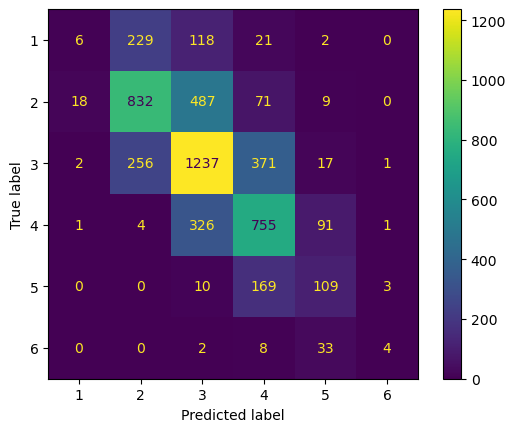

In [29]:
print("-"*50)
# kNN
print("kNN best params:", GS_kNN.best_params_) # Mejores parametros
kappa_kNN_train = GS_kNN.best_score_
print("Training Kappa:",kappa_kNN_train) # kappa Train
y_pred_kNN = GS_kNN.predict(X_test) # Predict Test
kappa_kNN_test = cohen_kappa_score(y_test, y_pred_kNN, weights="quadratic") # kappa Test
print("Testing Kappa:", kappa_kNN_test)
accuracy_kNN_test = accuracy_score(y_test, y_pred_kNN) # Accuracy Test
print("Testing Accuracy:", accuracy_kNN_test)
cm = metrics.confusion_matrix(y_test, y_pred_kNN)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = GS_kNN.classes_)
cm_display.plot()
plt.show()

## Random Forest

In [30]:
# RF
RF_clf = RandomForestClassifier(random_state=123)
# parameters = {'n_estimators':(50, 100, 200, 500),
#               'max_depth':[10, 50, 100, None],
#               'min_samples_leaf': [1,2,3,4],
#               }
parameters = {'n_estimators':(100, 500),
              'max_depth':[10, None],
              'min_samples_leaf': [1,4],
              }

GS_RF = GridSearchCV(estimator = RF_clf,
                    param_grid = parameters,
                    verbose = 3,
                    cv = 5,
                    scoring    = kappa_scorer)
GS_RF.fit(X_train, y_train) # Recorrer Hiperparametros
print("-"*50)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.700 total time=   2.6s
[CV 2/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.693 total time=   2.6s
[CV 3/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.711 total time=   2.5s
[CV 4/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.680 total time=   2.4s
[CV 5/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.697 total time=   2.5s
[CV 1/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.705 total time=  12.6s
[CV 2/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.691 total time=  12.4s
[CV 3/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.710 total time=  12.4s
[CV 4/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.681 total time=  12.6s
[CV 5/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, s

RF best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Training Kappa: 0.7002166254848445
Testing Kappa: 0.6864509738787344
Testing Accuracy: 0.5830926246870788


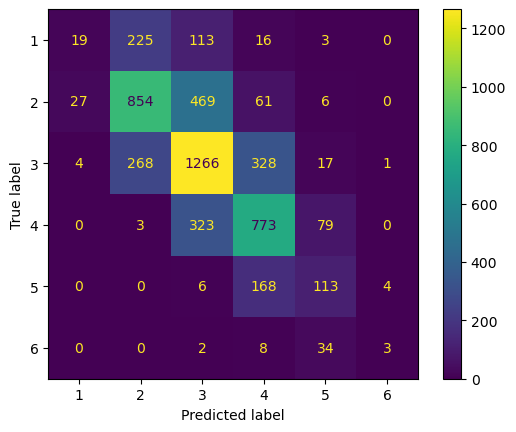

--------------------------------------------------


In [31]:
# RF
print("RF best params:", GS_RF.best_params_) # Mejores parametros
kappa_RF_train = GS_RF.best_score_
print("Training Kappa:",kappa_RF_train) # kappa Train
y_pred_RF = GS_RF.predict(X_test) # Predict Test
kappa_RF_test = cohen_kappa_score(y_test, y_pred_RF, weights="quadratic") # kappa Test
print("Testing Kappa:", kappa_RF_test)
accuracy_RF_test = accuracy_score(y_test, y_pred_RF) # Accuracy Test
print("Testing Accuracy:", accuracy_RF_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = GS_RF.classes_)
cm_display.plot()
plt.show()
print("-"*50)

# More features

In [32]:
class Preprocessor:
    def __init__(self) -> None:
        # self.twd = TreebankWordDetokenizer()
        # self.STOP_WORDS = set(stopwords.words('english'))
        
        # self.spacy_ner_model = spacy.load('en_core_web_sm',)
        # self.speller = Speller(lang='en')
        self.spellchecker = SpellChecker() 

    def quotes_count(self, row):
        summary = row['full_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        return len(quotes_from_summary)

    def spelling(self, text):
        wordlist=text.split()
        amount_miss = len(list(self.spellchecker.unknown(wordlist)))
        return amount_miss
    
    # def add_spelling_dictionary(self, tokens: List[str]) -> List[str]:
    #     """dictionary update for pyspell checker and autocorrect"""
    #     self.spellchecker.word_frequency.load_words(tokens)
    #     self.speller.nlp_data.update({token:1000 for token in tokens})
    
    def run(self, data: pd.DataFrame, mode:str) -> pd.DataFrame:
        
        # Text tokenization
        data["text_length"] = data["full_text"].apply(lambda x: len(x))
        data["text_tokens"] = data["full_text"].apply(lambda x: word_tokenize(x))
        data["text_tokens_count"] = data["text_tokens"].apply(lambda x: len(x))
        print("Token counting done")
        
        # # fix misspelling
        # data["fixed_text"] = data["full_text"].progress_apply(lambda x: self.speller(x))
        # print("Text correction done")
        
        # count misspelling
        data["splling_err_num"] = data["full_text"].progress_apply(self.spelling)
        print("Spelling mistake count done")
        
        # quotes count
        data['quotes_count'] = data.progress_apply(self.quotes_count, axis=1)
        print("Quote count done")
        
        return data
    
preprocessor = Preprocessor()

In [33]:
tmp = preprocessor.run(train.to_pandas(), mode="train")

# Merge the newly generated feature data with the previously generated feature data
train_extended_feats = train_feats.merge(tmp, on='essay_id', how='left')

feature_names = list(filter(lambda x: x not in ['essay_id','score'], train_feats.columns))
print('Features Number: ',len(feature_names))
train_extended_feats.head(3)

Token counting done


100%|██████████| 17307/17307 [00:11<00:00, 1442.72it/s]


Spelling mistake count done


100%|██████████| 17307/17307 [00:00<00:00, 98154.86it/s]

Quote count done


Features Number:  69


,essay_id,paragraph_50_cnt,paragraph_75_cnt,paragraph_100_cnt,paragraph_125_cnt,paragraph_150_cnt,paragraph_175_cnt,paragraph_200_cnt,paragraph_250_cnt,paragraph_300_cnt,...,word_len_q2,word_len_q3,full_text,score,paragraph,text_length,text_tokens,text_tokens_count,splling_err_num,quotes_count
0,000d118,1,1,1,1,1,1,1,1,1,...,4.0,5.0,Many people have car where they live. The thin...,3,[Many people have car where they live. The thi...,2677,"[Many, people, have, car, where, they, live, ....",545,54,4
1,000fe60,5,5,5,5,5,5,4,3,3,...,4.0,5.0,I am a scientist at NASA that is discussing th...,3,[I am a scientist at NASA that is discussing t...,1669,"[I, am, a, scientist, at, NASA, that, is, disc...",371,34,4
2,001ab80,4,4,4,4,4,4,4,4,4,...,4.0,5.0,People always wish they had the same technolog...,4,[People always wish they had the same technolo...,3077,"[People, always, wish, they, had, the, same, t...",605,43,6


# Extended Classification

In [34]:
train_extended_feats.keys()

Index(['essay_id', 'paragraph_50_cnt', 'paragraph_75_cnt', 'paragraph_100_cnt',
       'paragraph_125_cnt', 'paragraph_150_cnt', 'paragraph_175_cnt',
       'paragraph_200_cnt', 'paragraph_250_cnt', 'paragraph_300_cnt',
       'paragraph_350_cnt', 'paragraph_400_cnt', 'paragraph_500_cnt',
       'paragraph_600_cnt', 'paragraph_700_cnt', 'paragraph_25_cnt',
       'paragraph_49_cnt', 'paragraph_len_max', 'paragraph_sentence_cnt_max',
       'paragraph_word_cnt_max', 'paragraph_len_mean',
       'paragraph_sentence_cnt_mean', 'paragraph_word_cnt_mean',
       'paragraph_len_min', 'paragraph_sentence_cnt_min',
       'paragraph_word_cnt_min', 'paragraph_len_first',
       'paragraph_sentence_cnt_first', 'paragraph_word_cnt_first',
       'paragraph_len_last', 'paragraph_sentence_cnt_last',
       'paragraph_word_cnt_last', 'sentence_15_cnt', 'sentence_50_cnt',
       'sentence_100_cnt', 'sentence_150_cnt', 'sentence_200_cnt',
       'sentence_250_cnt', 'sentence_300_cnt', 'sentence_len_ma

In [35]:
X = train_extended_feats.drop(columns=["essay_id", "full_text", "score", "paragraph", "text_tokens"])
y = df["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=123, stratify = y)

## kNN

In [36]:
kNN_clf = KNeighborsClassifier()
parameters = {'n_neighbors':(1, 5, 10, 15),
                'weights':['uniform', 'distance'],
                'metric' : ['minkowski' , 'euclidean' , 'manhattan']}
GS_kNN= GridSearchCV(estimator = kNN_clf,
                param_grid = parameters,
                verbose = 3,
                cv = 5,
                scoring  = kappa_scorer
                )
GS_kNN.fit(X_train, y_train) # Recorrer Hiperparametros
print("kNN best params:", GS_kNN.best_params_, "Training Kappa:",GS_kNN.best_score_)
print("-"*50)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.599 total time=   0.2s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.582 total time=   0.2s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.600 total time=   0.2s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.594 total time=   0.2s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=uniform;, score=0.584 total time=   0.2s
[CV 1/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.599 total time=   0.1s
[CV 2/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.582 total time=   0.1s
[CV 3/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.600 total time=   0.1s
[CV 4/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.594 total time=   0.1s
[CV 5/5] END metric=minkowski, n_neighbors=1, weights=distance;, score=0.584 to

--------------------------------------------------
kNN best params: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}
Training Kappa: 0.6755691680763022
Testing Kappa: 0.6585123002978428
Testing Accuracy: 0.560369728480647


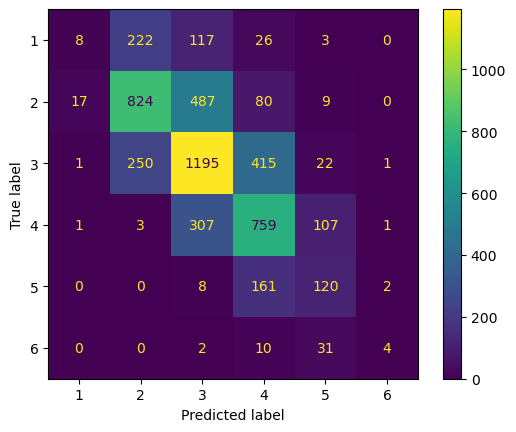

In [37]:
print("-"*50)
# kNN
print("kNN best params:", GS_kNN.best_params_) # Mejores parametros
kappa_kNN_train = GS_kNN.best_score_
print("Training Kappa:",kappa_kNN_train) # Kappa Train
y_pred_kNN = GS_kNN.predict(X_test) # Predict Test
kappa_kNN_test = cohen_kappa_score(y_test, y_pred_kNN, weights="quadratic") # Kappa Test
print("Testing Kappa:", kappa_kNN_test)
accuracy_kNN_test = accuracy_score(y_test, y_pred_kNN) # Accuracy Test
print("Testing Accuracy:", accuracy_kNN_test)
cm = metrics.confusion_matrix(y_test, y_pred_kNN)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = GS_kNN.classes_)
cm_display.plot()
plt.show()

## Random Forest

In [38]:
# RF
RF_clf = RandomForestClassifier(random_state=123)
# parameters = {'n_estimators':(50, 100, 200, 500),
#               'max_depth':[10, 50, 100, None],
#               'min_samples_leaf': [1,2,3,4],
#               }
parameters = {'n_estimators':(100, 500),
              'max_depth':[10, None],
              'min_samples_leaf': [1,4],
              }

GS_RF = GridSearchCV(estimator = RF_clf,
                    param_grid = parameters,
                    verbose = 3,
                    cv = 5,
                    scoring    = kappa_scorer)
GS_RF.fit(X_train, y_train) # Recorrer Hiperparametros
print("-"*50)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.696 total time=   2.7s
[CV 2/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.690 total time=   2.8s
[CV 3/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.708 total time=   2.6s
[CV 4/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.685 total time=   2.4s
[CV 5/5] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.699 total time=   2.6s
[CV 1/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.702 total time=  12.7s
[CV 2/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.692 total time=  12.6s
[CV 3/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.710 total time=  12.6s
[CV 4/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, score=0.686 total time=  12.6s
[CV 5/5] END max_depth=10, min_samples_leaf=1, n_estimators=500;, s

RF best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 500}
Training Kappa: 0.700526916731086
Testing Kappa: 0.683097228521128
Testing Accuracy: 0.5794338532640092


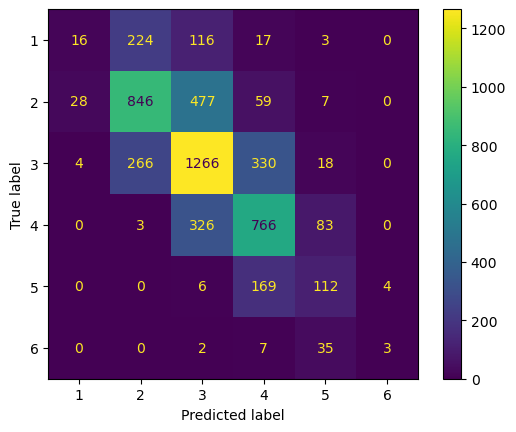

--------------------------------------------------


In [39]:
# RF
print("RF best params:", GS_RF.best_params_) # Mejores parametros
kappa_RF_train = GS_RF.best_score_
print("Training Kappa:",kappa_RF_train) # Kappa Train
y_pred_RF = GS_RF.predict(X_test) # Predict Test
kappa_RF_test = cohen_kappa_score(y_test, y_pred_RF, weights="quadratic") # Kappa Test
print("Testing Kappa:", kappa_RF_test)
accuracy_RF_test = accuracy_score(y_test, y_pred_RF) # Accuracy Test
print("Testing Accuracy:", accuracy_RF_test)
cm = metrics.confusion_matrix(y_test, y_pred_RF)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = GS_RF.classes_)
cm_display.plot()
plt.show()
print("-"*50)

# Feature Selection

In [ ]:
X = train_extended_feats.drop(columns=["essay_id", "full_text", "score", "paragraph", "text_tokens"])
y = df["score"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [ ]:
from sklearn.feature_selection import SelectKBest
selector = SelectKBest(k=10)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.30, random_state=123, stratify = y)

## kNN

In [ ]:
kNN_clf = KNeighborsClassifier()
parameters = {'n_neighbors':(1, 5, 10, 15),
                'weights':['uniform', 'distance'],
                'metric' : ['minkowski' , 'euclidean' , 'manhattan']}
GS_kNN= GridSearchCV(estimator = kNN_clf,
                param_grid = parameters,
                verbose = 3,
                cv = 5,
                scoring    = kappa_scorer
                )
GS_kNN.fit(X_train_selected, y_train) # Recorrer Hiperparametros
print("kNN best params:", GS_kNN.best_params_, "Training Kappa:",GS_kNN.best_score_)
print("-"*50)

In [ ]:
print("-"*50)
# kNN
print("kNN best params:", GS_kNN.best_params_) # Mejores parametros
kappa_kNN_train = GS_kNN.best_score_
print("Training Kappa:",kappa_kNN_train) # Kappa Train
y_pred_kNN = GS_kNN.predict(X_test_selected) # Predict Test
kappa_kNN_test = cohen_kappa_score(y_test, y_pred_kNN, weights="quadratic") # Kappa Test
print("Testing Kappa:", kappa_kNN_test)
accuracy_kNN_test = accuracy_score(y_test, y_pred_kNN) # Accuracy Test
print("Testing Accuracy:", accuracy_kNN_test)
cm = metrics.confusion_matrix(y_test, y_pred_kNN)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = GS_kNN.classes_)
cm_display.plot()
plt.show()